<a href="https://colab.research.google.com/github/Sevi9/colab/blob/main/%E2%80%9C%E2%80%9C%E2%80%9Cdeeplearning_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#第一部分配置环境
from google.colab import drive
drive.mount('/content/drive')
import os
path = "/content/drive/MyDrive" 
os.chdir(path)
!ls


In [ ]:
#第二部分下载资源
!mkdir d2l-zh && cd d2l-zh
!curl https://zh-v2.d2l.ai/d2l-zh.zip -o d2l-zh.zip
!unzip d2l-zh.zip && rm d2l-zh.zip
!pip install mxnet-cu101==1.7.0
!pip install -U d2l


In [ ]:
#第三部分进入文件夹下开始动手
import os
path = "/content/drive/MyDrive/d2l-zh" 
os.chdir(path)
import mxnet


In [ ]:
!pip install -U d2l

In [ ]:
!pip install matplotlib_inline


In [ ]:
!pip install matplotlib==3.0.0

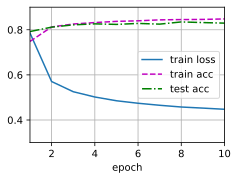

In [ ]:
#softmax回归的简洁实现
%matplotlib inline
import torch
from torch import nn
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
from IPython import display
batch_size=256
num_inputs = 784
num_outputs = 10
w = torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b = torch.zeros(num_outputs,requires_grad=True)

train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)
#pytorch不会隐式地调整输入的形状，因此要定义展平层（flatten）在线性层前调整网络输入的形状
net=nn.Sequential(nn.Flatten(),nn.Linear(784,10))#flatten将任何维度的tensor变成2d的tensor，第0维度保留，剩下全部展成一个向量
def accuracy(y_hat,y):
  """计算预测正确的数量"""
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: # y_hat.shape[1]>1表示不止一个类别，每个类别有各自的概率   
    y_hat = y_hat.argmax(axis=1) # y_hat.argmax(axis=1)为求行最大值的索引
  cmp = y_hat.type(y.dtype) == y # 先判断逻辑运算符==，再赋值给cmp，cmp为布尔类型的数据
  return float(cmp.type(y.dtype).sum()) # 获得y.dtype的类型作为传入参数，将cmp的类型转为y的类型（int型），然后再求和   
# 可以评估在任意模型net的准确率
def evaluate_accuracy(net,data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net,torch.nn.Module): # 如果net模型是torch.nn.Module实现的神经网络的话，将它变成评估模式     
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数，metric为累加器的实例化对象，里面存了两个数
    for X, y in data_iter:
        metric.add(accuracy(net(X),y),y.numel()) # net(X)将X输入模型，获得预测值。y.numel()为样本总数
    return metric[0] / metric[1] # 分类正确的样本数 / 总样本数
# 训练函数
def train_epoch_ch3(net, train_iter, loss, updater):
  if isinstance(net, torch.nn.Module):
    net.train() # 开启训练模式
  metric = Accumulator(3)
  for X, y in train_iter:
    y_hat = net(X)
    l = loss(y_hat,y) # 计算损失
    if isinstance(updater,torch.optim.Optimizer): # 如果updater是pytorch的优化器的话
      updater.zero_grad()
      l.mean().backward()  # 这里对loss取了平均值出来
      updater.step()
      metric.add(float(l)*len(y),accuracy(y_hat,y),y.size().numel()) # 总的训练损失、样本正确数、样本总数   
    else:
      l.sum().backward()
      updater(X.shape[0])
      metric.add(float(l.sum()),accuracy(y_hat,y),y.numel()) 
  return metric[0] / metric[2], metric[1] / metric[2] # 所有loss累加除以样本总数，总的正确个数除以样本总数  
class Accumulator:
  """在n个变量上累加"""
  def __init__(self,n):
    self.data = [0,0] * n
  def add(self, *args):
    self.data = [a+float(b) for a,b in zip(self.data,args)] # zip函数把两个列表第一个位置元素打包、第二个位置元素打包....
        
  def reset(self):
    self.data = [0.0] * len(self.data)
        
  def __getitem__(self,idx):
    return self.data[idx]
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None, xscale='linear',yscale='linear',
                fmts=('-','m--','g-.','r:'),nrows=1,ncols=1,
                figsize=(3.5,2.5)): 
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows,ncols,figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: d2l.set_axes(self.axes[0],xlabel,ylabel,xlim,ylim,xscale,yscale,legend)         
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)] 
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
# 总训练函数        
def train_ch3(net,train_iter,test_iter,loss,num_epochs,updater):
  animator = Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0.3,0.9],       
                       legend=['train loss','train acc','test acc'])
  for epoch in range(num_epochs):  # 变量num_epochs遍数据
   train_metrics = train_epoch_ch3(net,train_iter,loss,updater) # 返回两个值，一个总损失、一个总正确率
   test_acc = evaluate_accuracy(net,test_iter) # 测试数据集上评估精度，仅返回一个值，总正确率  
   animator.add(epoch+1,train_metrics+(test_acc,)) # train_metrics+(test_acc,) 仅将两个值的正确率相加，
   train_loss, train_acc = train_metrics  
def init_weights(m):#m为当前layer
  if type(m)==nn.Linear:
    nn.init.normal_(m.weight,std=0.01)#weight初始化为均值为0，标准差为0.01的随机值
net.apply(init_weights)#函数应用到net的每一层中完成初始化
loss=nn.CrossEntropyLoss(reduction="none")
trainer=torch.optim.SGD(net.parameters(),lr=0.1)#使用学习率为0.1的小批量随机梯度下降作为优化算法
#调用之前定义的训练函数来训练模型
num_epochs=10
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)


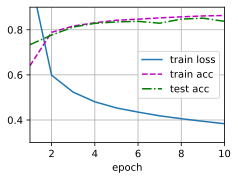

In [ ]:
#多层感知机从零开始实现
import torch
from torch import nn
from d2l import torch as d2l
batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)
#实现一个单隐藏层的多层感知机，包含256个隐藏单元
num_inputs,num_outputs,num_hiddens=784,10,256
w1=nn.Parameter(torch.randn(num_inputs,num_hiddens,requires_grad=True)*0.01)#随机行数为784，列数为256，×0.01为了把方差变为0.01
b1=nn.Parameter(torch.zeros(num_hiddens,requires_grad=True))#normal和randn区别在于normal可以自己设定方差而randn只是生成
w2=nn.Parameter(torch.randn(num_hiddens,num_outputs,requires_grad=True)*0.01)
b2=nn.Parameter(torch.zeros(num_outputs,requires_grad=True))
params=[w1,b1,w2,b2]
#实现ReLU激活函数
def relu(x):
  a=torch.zeros_like(x)#与x形状一样但元素均为0
  return torch.max(x,a)
#实现模型
def net(x):
  x=x.reshape((-1,num_inputs))#x为batchsize*784
  h=relu(x@w1+b1)#@是矩阵相乘
  return (h@w2+b2)
loss=nn.CrossEntropyLoss(reduction="none")
#训练——多层感知机训练过程同softmax回归训练过程
num_epochs,lr=10,0.1
updater=torch.optim.SGD(params,lr=lr)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,updater)
#可对比上一张图的loss下降，精度没有改变太多，模型更大，数据拟合性更好，损失下降

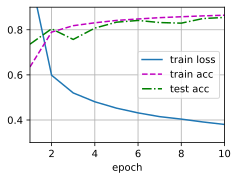

In [ ]:
#多层感知机的简洁实现
import torch
from torch import nn
from d2l import torch as d2l
net = nn.Sequential(nn.Flatten(),nn.Linear(784,256),
                    nn.ReLU(),
                    nn.Linear(256,10))

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights);
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

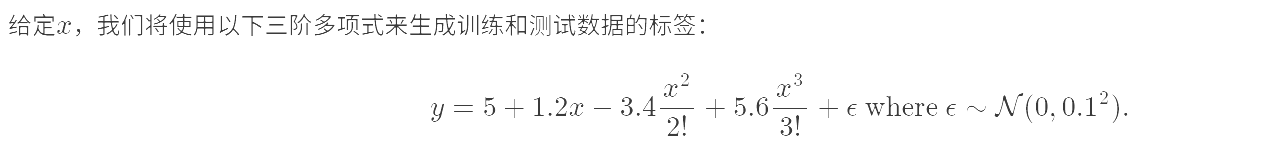

weight: [[ 4.928019    1.4552926  -3.0073779   4.580907   -1.0926691   1.0746306
  -0.31902525  0.12743907  0.07522329 -0.20615456  0.13807818 -0.03325684
  -0.22099763  0.02959972  0.18992363 -0.13275228 -0.01626485 -0.20111902
  -0.11352906  0.05544929]]


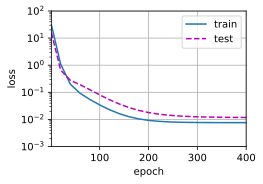

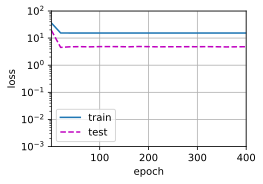

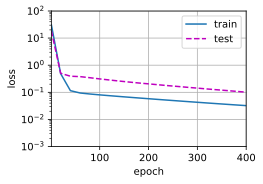

In [ ]:
from numpy.lib.polynomial import poly
#模型选择、欠拟合和过拟合
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
max_degree=20#输入特征数为20，产生20维向量
n_train,n_test=100,100
true_w=np.zeros(max_degree)
true_w[0:4]=np.array([5,1.2,-3.4,5.6])#w也为20，其余为0而已
features=np.random.normal(size=(n_train+n_test,1))
np.random.shuffle(features)
poly_features=np.power(features,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
  poly_features[:,i]/=math.gamma(i+1)#gamma(n)=(n-1)!
labels=np.dot(poly_features,true_w)
labels+=np.random.normal(scale=0.1,size=labels.shape)
true_w,features,poly_features,labels=[torch.tensor(x,dtype=torch.float32) for x in [true_w,features,poly_features,labels]]
features[:2],poly_features[:2,:],labels[:2]
#评估模型在给定数据集上的损失
def evaluate_loss(net,data_iter,loss):
  metric=d2l.Accumulator(2)
  for x,y in data_iter:
    out=net(x)
    y=y.reshape(out.shape)
    l=loss(out,y)
    metric.add(l.sum(),l.numel())
  return metric[0]/metric[1]
def train(train_features,test_features,train_labels,test_labels,num_epochs=400):
  loss=nn.MSELoss()
  input_shape=train_features.shape[-1]#表列数，行向量的元素总数
  net=nn.Sequential(nn.Linear(input_shape,1,bias=False))#单层线性网络softmax
  batch_size=min(10,train_labels.shape[0])#batchsize为10
  train_iter=d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size)
  test_iter=d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size,is_train=False)
  trainer=torch.optim.SGD(net.parameters(),lr=0.01)
  animator=d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',xlim=[1,num_epochs],ylim=[1e-3,1e2],legend=['train','test'])
  for epoch in range(num_epochs):
    d2l.train_epoch_ch3(net,train_iter,loss,trainer)
    if epoch==0 or (epoch+1)%20==0:
      animator.add(epoch+1,(evaluate_loss(net,train_iter,loss),evaluate_loss(net,test_iter,loss)))
  print('weight:',net[0].weight.data.numpy())
train(poly_features[:n_train,:4],poly_features[n_train:,:4],labels[:n_train],labels[n_train:])#从特征多项式中选取前四个维度
train(poly_features[:n_train,:2],poly_features[n_train:,:2],labels[:n_train],labels[n_train:])#欠拟合，只选了两个维度
train(poly_features[:n_train,:],poly_features[n_train:,:],labels[:n_train],labels[n_train:])#过拟合，所有维度都选择

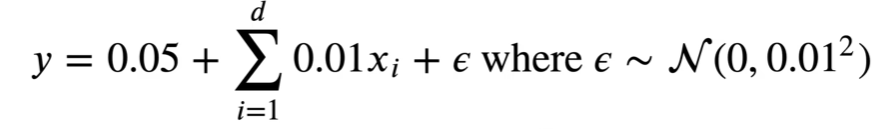

w的L2范数是： 0.3859468400478363


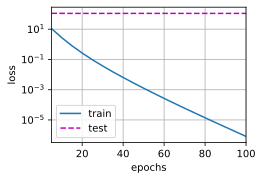

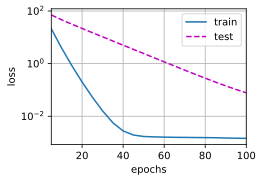

In [ ]:
#权重衰减
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
#生成数据如上图多项式
n_train,n_test,num_inputs,batch_size=20,100,200,5#选少的训练样本防止过拟合
true_w,true_b=torch.ones((num_inputs,1))*0.01,0.05
train_data=d2l.synthetic_data(true_w,true_b,n_train)
train_iter=d2l.load_array(train_data,batch_size)
test_data=d2l.synthetic_data(true_w,true_b,n_test)
test_iter=d2l.load_array(test_data,batch_size,is_train=False)
#初始化模型参数
def init_params():
  w=torch.normal(0,1,size=(num_inputs,1),requires_grad=True)#均值为0，方差为1，size为200*1的向量
  b=torch.zeros(1,requires_grad=True)
  return [w,b]
#定义L2范数惩罚项
def l2_penalty(w):
  return torch.sum(w.pow(2))/2#换成L1范数更新权重——torch.abs(w)
def train(lambd):
  w,b=init_params()
  net,loss=lambda x:d2l.linreg(x,w,b),d2l.squared_loss#lambda为匿名函数，相当于定义了一个net（x）
  num_epochs,lr=100,0.003
  animator=d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',xlim=[5,num_epochs],legend=['train','test'])
  for epoch in range(num_epochs):
    for x,y in train_iter:
      with torch.enable_grad():
        l=loss(net(x),y)+lambd*l2_penalty(w)
      l.sum().backward()
      d2l.sgd([w,b],lr,batch_size)
    if (epoch+1)%5==0:
      animator.add(epoch+1,(d2l.evaluate_loss(net,train_iter,loss),d2l.evaluate_loss(net,test_iter,loss)))
  print('w的L2范数是：',torch.norm(w).item())
train(lambd=0)#没有L2范数可以看出过拟合明显
train(lambd=3)#去过拟合效果明显


w的L2范数： 0.3862219750881195


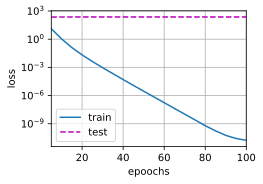

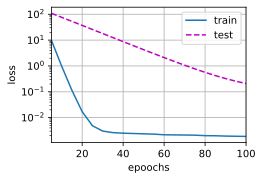

In [ ]:
#权重衰减的简洁实现
def train_concise(wd):
  net=nn.Sequential(nn.Linear(num_inputs,1))
  for param in net.parameters():
    param.data.normal_()
  loss=nn.MSELoss()
  num_epochs,lr=100,0.003
  #基本所有优化算法都会提供weight decay项
  trainer=torch.optim.SGD([{"params": net[0].weight,'weight_decay': wd},{"params":net[0].bias}],lr=lr)#net[0]指的是nn.Sequential里的第一个全连接层
  animator=d2l.Animator(xlabel='epoochs',ylabel='loss',yscale='log',xlim=[5,num_epochs],legend=['train','test'])
  for epoch in range(num_epochs):
    for x,y in train_iter:
      with torch.enable_grad():
        trainer.zero_grad()
        l=loss(net(x),y)
      l.backward()
      trainer.step()
    if (epoch + 1) % 5 == 0:
      animator.add(epoch + 1,
                   (d2l.evaluate_loss(net, train_iter, loss),
                    d2l.evaluate_loss(net, test_iter, loss)))
  print('w的L2范数：', net[0].weight.norm().item())
train_concise(0)
train_concise(3)

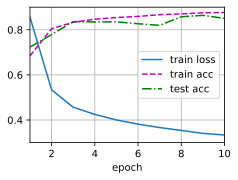

In [ ]:
#dropout的实现
import torch 
from torch import nn
from d2l import torch as d2l
def dropout_layer(x,dropout):
  assert 0<=dropout<=1#判断assert后的表达式是否为true，若为true就继续执行下面代码否则触发异常
  if dropout==1:
    return torch.zeros_like(x)
  if dropout==0:
    return x
  mask=(torch.rand(x.shape)>dropout).float()#mask是一个与x shape相同的布尔矩阵，代表哪些位置保留，哪些位置dropout，mask为一个x.shape维度的0，1数组
  #转换为01的float便于return
  return mask*x/(1.0-dropout)
x=torch.arange(16,dtype=torch.float32).reshape((2,8))
print(x),print(dropout_layer(x,0.)),print(dropout_layer(x,0.5)),print(dropout_layer(x,1.))
#定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元
num_inputs,num_outputs,num_hidden1,num_hidden2=784,10,256,256
dropout1,dropout2=0.2,0.5
class Net(nn.Module):
  def __init__(self,num_inputs,num_outputs,num_hidden1,num_hidden2,is_training=True):#注意istraining=true才使用dropout
    super(Net,self).__init__()
    self.num_inputs=num_inputs
    self.training=is_training
    self.lin1=nn.Linear(num_inputs,num_hidden1)
    self.lin2=nn.Linear(num_hidden1,num_hidden2)
    self.lin3=nn.Linear(num_hidden2,num_outputs)
    self.relu=nn.ReLU()
  def forward(self,x):#实例化Net后自动调用forward
    h1=self.relu(self.lin1(x.reshape((-1,self.num_inputs))))
    if self.training==True:#若在训练则作用dropout
      h1=dropout_layer(h1,dropout1)
    h2=self.relu(self.lin2(h1))
    if self.training==True:#同上
      h2=dropout_layer(h2,dropout2)
    out=self.lin3(h2)
    return out
net=Net(num_inputs,num_outputs,num_hidden1,num_hidden2)
num_epochs,lr,batch_size=10,0.5,256
loss=nn.CrossEntropyLoss(reduction="none")
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)
trainer=torch.optim.SGD(net.parameters(),lr=lr)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

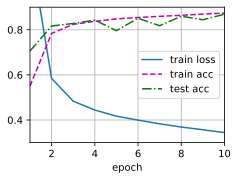

In [ ]:
#dropout的简洁实现
net=nn.Sequential(
    nn.Flatten(),nn.Linear(784,256),nn.ReLU(),#先将输入拉平flatten为2维图像，第一个全连接层
    nn.Dropout(dropout1),nn.Linear(256,256),nn.ReLU(),#加入dropout layer
    nn.Dropout(dropout2),nn.Linear(256,10)#加入dropout layer
)
def init_weights(m):
  if type(m)==nn.Linear:
    nn.init.normal_(m.weight,std=0.01)
net.apply(init_weights);
trainer=torch.optim.SGD(net.parameters(),lr=lr)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载../data/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载../data/kaggle_house_pred_test.csv...
(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
fold1,train log rmse0.170480,valid log rmse0.157213
fold2,train log rmse0.162138,valid log rmse0.188192
fold3,train log rmse0.164611,valid log rmse0.168737
fold4,train log rmse0.168037,valid log rmse0.154843
fold5,train log rmse0.162825,valid log rmse0.182937
5-折验证：平均训练log rmse：0.165618,平均验证log rmse：0.170384
train log rmse0.162443


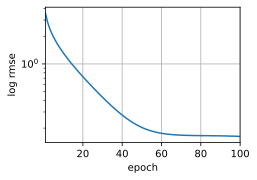

In [ ]:
#kaggle预测房价
import hashlib
import os
import tarfile
import zipfile
import requests
DATA_HUB=dict()
DATA_URL='http://d2l-data.s3-accelerate.amazonaws.com/'
def download(name,cache_dir=os.path.join('..','data')):
  #下载一个DATA_HUB中的文件返回本地文件名
  assert name in DATA_HUB,f"{name} 不存在于 {DATA_HUB}."
  url,shal_hash=DATA_HUB[name]
  os.makedirs(cache_dir,exist_ok=True)
  fname=os.path.join(cache_dir,url.split('/')[-1])
  if os.path.exists(fname):
    shal=hashlib.sha1()
    with open(fname,'rb') as f:
      while True:
        data=f.read(1048576)
        if not data:
          break
        shal.update(data)
    if shal.hexdigest()==shal_hash:
      return fname#命中缓存
  print(f'正在从{url}下载{fname}...')
  r = requests.get(url,stream=True,verify=True)
  with open(fname, 'wb') as f:
    f.write(r.content)
  return fname
def download_extract(name, folder=None): 
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)
#使用pandas读入并处理数据
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
DATA_HUB['kaggle_house_train']={DATA_URL+'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce'}
DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')  
train_data=pd.read_csv(download('kaggle_house_train'))
test_data=pd.read_csv(download('kaggle_house_test'))
print(train_data.shape)
print(test_data.shape) 
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])
#因为第一个特征为ID故删除
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))#iloc遵循左闭右开原则所以traindata包含最后一列，这里iloc切片索引删除了traindata的第一列和最后一列
#将所有缺失值替换为相应特征的平均值，通过将特征重新缩放到零均值和单位方差来标准化数据，即列值进行缩放变成正态分布
numeric_features=all_features.dtypes[all_features.dtypes!='object'].index
all_features[numeric_features]=all_features[numeric_features].apply(lambda x:(x-x.mean())/(x.std()))#训练集和测试集放到一起算均值方差，均值为0，方差为1
all_features[numeric_features]=all_features[numeric_features].fillna(0)#把not a number（未特征采样的data）填充为0
#处理离散值,对字符串类型用一次独热编码替换
all_features=pd.get_dummies(all_features,dummy_na=True)#哑元变量，dummy_na设为True时，对nan类型也进行编码
all_features.shape
#从pandas格式中提取numpy格式并将其转换为张量表示
n_train=train_data.shape[0]
train_features=torch.tensor(all_features[:n_train].values,dtype=torch.float32)
test_features=torch.tensor(all_features[n_train:].values,dtype=torch.float32)#理解为切片，定义起始位置和终止位置，features中train和test合并，这里要分开
train_labels=torch.tensor(train_data.SalePrice.values.reshape(-1,1),dtype=torch.float32)
#训练
loss=nn.MSELoss()
in_features=train_features.shape[1]#in_feature=331
def get_net():
  net=nn.Sequential(nn.Linear(in_features,1))#单层线性回归
  return net
#关心相对误差(y-y^)/y用价格预测的对数来衡量差异
def log_rmse(net,features,labels):
  clipped_preds=torch.clamp(net(features),1,float('inf'))#clamp限制输出为1到正无穷
  rmse=torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))#一般y取log后会更接近正态分布，用回归性质比较好
  return rmse.item()
#训练函数将借助Adam优化器
def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
  train_ls,test_ls=[],[]
  train_iter=d2l.load_array((train_features,train_labels),batch_size)
  optimizer=torch.optim.Adam(net.parameters(),lr=learning_rate,weight_decay=weight_decay)#可以理解为平滑的SGD，对学习率较为不敏感，但SGD上限更高
  for epoch in range(num_epochs):
    for x,y in train_iter:
      optimizer.zero_grad()
      l=loss(net(x),y)
      l.backward()
      optimizer.step()
    train_ls.append(log_rmse(net,train_features,train_labels))
    if test_labels is not None:
      test_ls.append(log_rmse(net,test_features,test_labels))
  return train_ls,test_ls
#K折交叉验证
def get_k_fold_data(k,i,x,y):
  assert k>1
  fold_size=x.shape[0]//k#每一折为样本数/k
  x_train,y_train=None,None
  for j in range(k):
    idx=slice(j*fold_size,(j+1)*fold_size)
    x_part,y_part=x[idx,:],y[idx]
    if j==i:#j等于当前折数i，把这一折作为验证集，其余作为训练集
      x_valid,y_valid=x_part,y_part
    elif x_train is None:#还没有第一次看到就先存起来
      x_train,y_train=x_part,y_part
    else:#train和part concat起来做训练集
      x_train=torch.cat([x_train,x_part],0)
      y_train=torch.cat([y_train,y_part],0)
  return x_train,y_train,x_valid,y_valid#最后返回训练集和验证集
#返回训练和验证误差的平均值
def k_fold(k,x_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
  train_l_sum,valid_l_sum=0,0
  for i in range(k):
    data=get_k_fold_data(k,i,x_train,y_train)
    net=get_net()
    train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)#*为解码，变成前面返回的四个数据
    train_l_sum+=train_ls[-1]#-1代表只取每一折最后一轮的损失loss
    valid_l_sum+=valid_ls[-1]
    if i==0:
      d2l.plot(list(range(1,num_epochs+1)),[train_ls,valid_ls],xlabel='epoch',ylabel='rmse',xlim=[1,num_epochs],legend=['train','valid'],yscale='log')
    print(f'fold{i+1},train log rmse{float(train_ls[-1]):f},'f'valid log rmse{float(valid_ls[-1]):f}')
  return train_l_sum/k,valid_l_sum/k#loss求和做平均
k,num_epochs,lr,weight_decay,batch_size=5,100,5,0,64
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证：平均训练log rmse：{float(train_l):f},'f'平均验证log rmse：{float(valid_l):f}')#train和valid重合较好，只能说没有overfitting但不能评价是好是坏
#提交自己的kaggle预测
def train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size):#将调好的超参放到完整的训练集上训练一次
  net=get_net()
  train_ls,_=train(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
  d2l.plot(np.arange(1,num_epochs+1),[train_ls],xlabel='epoch',ylabel='log rmse',xlim=[1,num_epochs],yscale='log')
  print(f'train log rmse{float(train_ls[-1]):f}')
  preds=net(test_features).detach().numpy()#测试集无标注，将网络应用到测试集
  #将其重新格式化以导出到Kaggle
  test_data['SalePrice']=pd.Series(preds.reshape(1,-1)[0])
  submission=pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
  submission.to_csv('submission.csv',index=False)#submission为kaggle上要提交的文件
train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size)

In [ ]:
!pip install pandas==0.20.3

In [ ]:
#竞赛 房价预测
